# Uniformity on the 2D Plane

## -- really on the unit sphere
### 2019-09-21

This notebook is where the work that led to the SecondBestFriends algorithm was performed

The contents are not really organized in a sensical way at this time.

I started with some basic geometric ideas inspired by Gauss that some sort of comparison of the perimeter and the area might give a useful metric.  I was able to pretty much prove that this is a bad approach.

I looked at the cummulative cross product of points on a unit sphere.  Regardless of orientation, the Nth root of the cummulative cross product (where N is the number of points) seems to give the geometric mean of the "spacing" of the points.  This is an interesting result that could be used as the input to a grid generator.  For instance the expectation for even spacing would be for 100 points to land in a grid that is 10X this provided distance.  One still has the problem of assiging a grid that actually gives this result.

Then I learned that a-priori methods of determining uniformity in dimensions > 1 are still a topic of research.  If you have a specific grid you want to check against (not really a-priori), you are good.  Otherwise not.  

As a way of avoiding the need for a pre-known grid or to generate a good one given an arbitrarily shaped set of points, I came up with the Convex Hull based HullPie algorithm.  

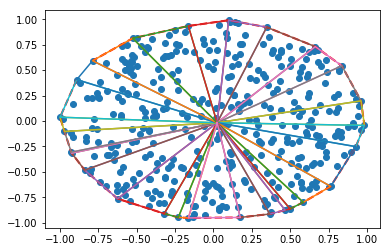

While debugging the HullPie code, I thought of the SecondBestFriends algorithm.  It seems to give the best results while not being as fast has HullPie.


Some papers:
* https://stats.stackexchange.com/questions/113464/understanding-scipy-kolmogorov-smirnov-test  -- speaks to useless of pvalue returned by kstest for uniform distribution.
* https://stackoverflow.com/questions/13005294/measure-the-uniformity-of-distribution-of-points-in-a-2d-square
* https://stats.stackexchange.com/questions/27288/two-dimensional-kolmogorov-smirnov
* http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1983MNRAS.202..615P&defaultprint=YES&filetype=.pdf
* http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1987MNRAS.225..155F&amp;data_type=PDF_HIGH&amp;whole_paper=YES&amp;type=PRINTER&amp;filetype=.pdf
* https://stats.stackexchange.com/questions/406406/test-of-uniform-distribution-using-ks-test-and-chi-square-in-r
* https://stats.stackexchange.com/questions/113464/understanding-scipy-kolmogorov-smirnov-test
* 


Coding references:
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html
* https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m
* https://stackoverflow.com/questions/31909945/obtain-eigen-values-and-vectors-from-sklearn-pca
* https://en.wikipedia.org/wiki/Shoelace_formula

In [1]:
import io, math, numpy, sys
import numpy as np
import scipy.optimize as opt
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [2]:
TEST_DATA_FILE="tracy_test_data.tab"
AREA_EARTH_SQ_KM=510100000.0 # 510.1 million km²
RADIAN_2_KM=6371.0
SQ_RADIAN_2_SQ_KM=AREA_EARTH_SQ_KM/(4.0*math.pi)

In [3]:
def xyz2angles(xyz):
    lon_radians = numpy.arctan2(xyz[1], xyz[0])
    lat_radians = numpy.arcsin(xyz[2])
    return np.array([lat_radians, lon_radians])

def angles2xyz(latlon_radians):
    xyz = [math.cos(latlon_radians[0]) * math.cos(latlon_radians[1]), math.cos(latlon_radians[0]) * math.sin(latlon_radians[1]), math.sin(latlon_radians[0])]
    return np.array(xyz)


In [4]:
def degrees_to_radians(angle):
    rad = math.pi * angle / 180.0
    return rad
np_degrees_to_radians = np.vectorize(degrees_to_radians)

def radians_to_degrees(rad):
    deg = 180.0 * rad / math.pi
    return deg
np_radians_to_degrees = np.vectorize(radians_to_degrees)

def xyz2latlon(xyz):
    latlon_radians = xyz2angles(xyz)
    lat_deg = radians_to_degrees(latlon_radians[0])
    lon_deg = radians_to_degrees(latlon_radians[1])
    return np.array([lat_deg, lon_deg])
    
def latlon2xyz(latlon_deg):
    xyz = angles2xyz([degrees_to_radians(latlon_deg[0]), degrees_to_radians(latlon_deg[1])])
    return xyz


In [5]:
# Assuming real input will look like: <latitude>\t<longitude>\t<tag>

def genTestData():
    with open(TEST_DATA_FILE, "w+") as g:
        Box=[ (30.15, -97.83), (30.35, -97.62)]
        DotParams = {
            "LowerLeft-Coarse": [ (Box[0][0], (Box[0][0] + Box[1][0])/2, 0.05)
                                 , (Box[0][1], (Box[0][1] + Box[1][1])/2, 0.05)  ],
            "Box-Fine": [ (Box[0][0], Box[1][0], 0.01)
                                 , (Box[0][1], Box[1][1], 0.01)  ],
            "UpperRight-Medium": [ ((Box[0][0] + Box[1][0])/2, Box[1][0], 0.03)
                                 , ((Box[0][1] + Box[1][1])/2, Box[1][1], 0.03)  ]
        }
        for tag in DotParams:
            latRange = DotParams[tag][0]
            lonRange = DotParams[tag][1]
            for lat in np.arange(*latRange):
                for lon in np.arange(*lonRange):
                    line = '\t'.join([ str(lat), str(lon), tag ]) + '\n'
                    g.write(line)
#           

In [6]:
genTestData()

In [7]:
def loadData(tracyDataPath):
    data = {}
    with open(tracyDataPath, "r") as f:
        for line in f:
            line = line.rstrip()
            A = line.split('\t')
            if len(A)==3:
                (lat, lon, tag) = A
                if tag not in data:
                    data[tag] = []
                data[tag].append( np.array([lat, lon], dtype=float) )
    return data

In [8]:
testData = loadData(TEST_DATA_FILE)

In [9]:
latlon2xyz([0.0,0.0])

array([1., 0., 0.])

In [10]:
def shoeLace(XY):
    accum = 0.0
    def nextIdx(ii):
        if ii+1 == len(XY):
            return 0
        return ii+1
    for i in range(len(XY)):
        accum += (XY[i][0]*XY[nextIdx(i)][1])
        accum -= (XY[i][1]*XY[nextIdx(i)][0])
    return abs(accum)

In [11]:
# XY in radians
def shoeLace2(XY):
    meanVect = np.sum(XY, axis=0)/len(XY)
    angles = [(math.atan2((XY[i] - meanVect)[0], (XY[i] - meanVect)[1]), i) for i in range(len(XY))]
    angles.sort()
    
    accum = 0.0
    def nextIdx(ii):
        if ii+1 == len(XY):
            return 0
        return ii+1
    def xyIdx(angleIdx):
        return angles[angleIdx][1]
    for i in range(len(XY)):
        accum += (XY[xyIdx(i)][0]*XY[xyIdx(nextIdx(i))][1])
        accum -= (XY[xyIdx(i)][1]*XY[xyIdx(nextIdx(i))][0])
    return abs(accum)

In [12]:
# Some background

[-6.68884023e-16  4.00000000e+00 -4.00000000e+00]


,points,edge-points,ratio,N,inner
0,9,8,1.0,3,1
1,16,12,1.0,4,4
2,25,16,1.0,5,9
3,36,20,1.0,6,16
4,49,24,1.0,7,25
5,64,28,1.0,8,36


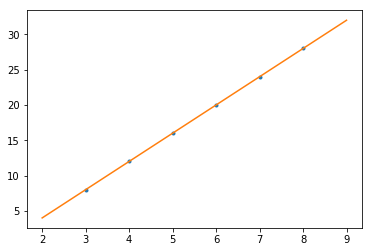

In [13]:
# Square grid:
#
#  For a square grid we find that the ratio of total points to 
#  hull points is ((4*math.sqrt(totalPoints))-4) = hullPoints
#
def takeALookAtSquareGrid():
    tableData = []
    xFit = []
    yFit = []
    for singleEdgeCount in range(3,9,1):
        allEdgeCount = 4 * (singleEdgeCount-2) + 4
        innerPoints = (singleEdgeCount - 2)**2
        totalPoints = allEdgeCount + innerPoints
        xFit.append(math.sqrt(totalPoints))
        yFit.append(allEdgeCount)
        tableData.append([totalPoints, allEdgeCount, (4*(math.sqrt(totalPoints)-1))/allEdgeCount, singleEdgeCount, innerPoints])
    f = np.polyfit(xFit, yFit, 2)
    print(f)
    
    p = np.poly1d(f)
    x2 = np.linspace(min(xFit)-1, max(xFit)+1, 100)
    plt.plot(xFit, yFit, '.', x2, p(x2), '-')
    
    df = pd.DataFrame(tableData, columns=['points', 'edge-points', 'ratio', 'N', 'inner'])
    return df
takeALookAtSquareGrid()

In [14]:
# even distribution over a circle
#
#    http://www.anderswallin.net/2009/05/uniform-random-points-in-a-circle-using-polar-coordinates/
#
#    Note: it is pretty clear that total number of points needs to be largish (900+)
#        before a circular dist starts to look even ... pretty good test data.
def takeALookAtCircularDist():
    tableData = []
    xFit = []
    yFit = []
    for i in range(30,41,1):
        x = []
        y = []
        totalPoints = i**2
        for j in range(totalPoints):
            r = math.sqrt(random.uniform(0.0, 1.0))
            theta = math.pi * (1.0  -  (2.0 * random.random()))
            x.append(r * math.cos(theta))
            y.append(r * math.sin(theta))
        # plt.plot(x, y, '.')
        
        points = np.array([np.array([x[i],y[i]]) for i in range(len(x))])
        hull = ConvexHull(points)
        hullPoints = len(hull.vertices)
        
        xFit.append(math.sqrt(totalPoints))
        yFit.append(hullPoints)
        
        tableData.append([totalPoints, hullPoints, math.pi * (math.sqrt(totalPoints)-1)/hullPoints, i ])
        
    f = np.polyfit(xFit, yFit, 2)
    print(f)
    df = pd.DataFrame(tableData, columns=['points', 'hull-points', 'ratio', 'N'])
    return df
takeALookAtCircularDist()

[ 5.71095571e-02 -3.46130536e+00  8.57062937e+01]


,points,hull-points,ratio,N
0,900,30,3.036873,30
1,961,37,2.547237,31
2,1024,33,2.951193,32
3,1089,36,2.792527,33
4,1156,36,2.879793,34
5,1225,30,3.560472,35
6,1296,34,3.233992,36
7,1369,33,3.427192,37
8,1444,44,2.641794,38
9,1521,33,3.617592,39


In [15]:
# So we see that for an arbitrary region, hull points versus total points alone
# is an insufficient metric for evaluating evenness of distribution.

-3.095478010037236
3.1186418549085393
3.0605261276680125
-3.076597195378682
3.1184380082874736
3.0608659053566036
-3.0155984268486606
-2.9898614979623743
-3.0129989643209707
-3.082502714782291
-3.06170776442501
-3.0994051656925534
-3.0056069783311194
-3.0939466701559852
-3.0183000398085342
3.077155841787232
-3.071614544232788
-3.005684743623054
[14.53846154  8.53846154 24.53846154  9.53846154 27.53846154 11.53846154
  7.53846154 21.53846154 17.53846154 12.53846154 10.53846154 13.53846154
 12.53846154 11.53846154 12.53846154 16.53846154  6.53846154 27.53846154
 16.53846154  8.53846154 32.53846154 17.53846154 31.53846154 19.53846154
  2.53846154 18.53846154]
[ 67.72988121  83.9452387   52.35712933  64.16115666  87.10073765
  54.18084926  92.21332533  66.7697331   72.20710553  87.86945427
  85.63599987  72.46153208  57.35983907 115.80070875  85.8644025
  91.82007019 131.72241004  61.58615721  64.41609599  68.7200426
  64.25777716  56.41126532 105.08047841  90.65334482 185.50726775
  81.43

,points,avg(ρ),min(ρ),max(ρ),σ(norm(ρ)),N
0,400,82.587352,52.357129,185.507268,0.924154,20


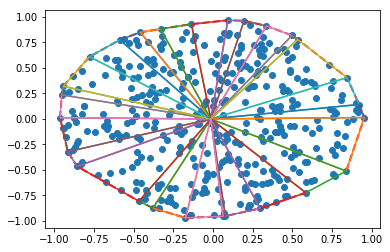

In [16]:
def takeALookAtHullPies():
    tableData = []
    xFit = []
    yFit = []
    for i in range(20,21,1):
        x = []
        y = []
        totalPoints = i**2
        for j in range(totalPoints):
            r = math.sqrt(random.uniform(0.0, 1.0))
            theta = random.uniform(-math.pi, math.pi)
            x.append(r * math.cos(theta))
            y.append(r * math.sin(theta))
        points = np.array([np.array([x[i],y[i]]) for i in range(len(x))])
        plt.plot(points[:,0], points[:,1], 'o')
        center = np.sum(points, axis=0)/totalPoints
        hull = ConvexHull(points)
        plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
        angles=[]
        areas=[]
        def nextIdx(vertidx):
            if vertidx + 1 == len(hull.vertices):
                return 0
            return vertidx + 1
        def vertPt(vertidx):
            return points[hull.vertices[vertidx]]
        #
        for vertidx in range(len(hull.vertices)):
            angle = math.atan2(vertPt(vertidx)[0] - center[0], vertPt(vertidx)[1] - center[1])
            angles.append(angle)
        # Now we need to sort the angles ... and rearrange the vertex indices
        angles = sorted([ (angles[vtxid], vtxid) for vtxid in range(len(hull.vertices)) ])
        
        for angleIdx in range(len(angles)):
            (angle, vertidx) = angles[angleIdx]
            nextAngleIdx = nextIdx(angleIdx)
            (nextAngle, nextVertIdx) = angles[nextAngleIdx]
            triangle = np.zeros((4,2))
            triangle[0] = center
            triangle[1] = vertPt(vertidx)
            triangle[2] = vertPt(nextVertIdx)
            triangle[3] = center            
            areas.append(shoeLace(triangle))
            plt.plot(triangle[:, 0], triangle[:, 1])
        #
        
        def triangleIndex(ptXY):
            ptAngle = math.atan2(ptXY[0] - center[0], ptXY[1] - center[1])
            # minus 1: We don't actually want to wrap around, + to - transition handled by default return
            for angleIdx in range(len(angles)-1):
                (angle, vertIdx) = angles[angleIdx]
                nextAngleIdx = nextIdx(angleIdx)
                (nextAngle, nextVertIdx) = angles[nextAngleIdx]
                if angle <= ptAngle and ptAngle < nextAngle:
                    return angleIdx
            print( ptAngle )
            return len(angles)-1
        #
        count = np.full(len(angles), 0.5 + 1.0/len(angles))
        for ptidx in range(totalPoints):
            triidx = triangleIndex(points[ptidx])
            count[triidx] = count[triidx] + 1
        densities = np.array([ count[i]/areas[i] for i in range(len(areas)) ])
        densityAvg = np.sum(densities)/len(densities)
        densityStdD = np.std((densities-min(densities))/(densityAvg-min(densities)))
        tableData.append([totalPoints, densityAvg, min(densities), max(densities), densityStdD, i])
        print(count)
        print(densities)
    df = pd.DataFrame(tableData, columns=['points', 'avg(ρ)', 'min(ρ)', 'max(ρ)', 'σ(norm(ρ))', 'N'])
    return df
#
takeALookAtHullPies()

In [17]:
# Now with a range of point sizes and no plots:

def takeALookAtHullPies2():
    tableData = []
    xFit = []
    yFit = []
    for i in range(20,40,1):
        x = []
        y = []
        totalPoints = i**2
        for j in range(totalPoints):
            r = math.sqrt(random.uniform(0.0, 1.0))
            theta = random.uniform(-math.pi, math.pi)
            x.append(r * math.cos(theta))
            y.append(r * math.sin(theta))
        points = np.array([np.array([x[i],y[i]]) for i in range(len(x))])
        center = np.sum(points, axis=0)/totalPoints
        hull = ConvexHull(points)
        angles=[]
        areas=[]
        def nextIdx(vertidx):
            if vertidx + 1 == len(hull.vertices):
                return 0
            return vertidx + 1
        def vertPt(vertidx):
            return points[hull.vertices[vertidx]]
        #
        for vertidx in range(len(hull.vertices)):
            angle = math.atan2(vertPt(vertidx)[0] - center[0], vertPt(vertidx)[1] - center[1])
            angles.append(angle)
        # Now we need to sort the angles ... and rearrange the vertex indices
        angles = sorted([ (angles[vtxid], vtxid) for vtxid in range(len(hull.vertices)) ])
        
        for angleIdx in range(len(angles)):
            (angle, vertidx) = angles[angleIdx]
            nextAngleIdx = nextIdx(angleIdx)
            (nextAngle, nextVertIdx) = angles[nextAngleIdx]
            triangle = np.zeros((3,2))
            triangle[0] = center
            triangle[1] = vertPt(vertidx)
            triangle[2] = vertPt(nextVertIdx)
            areas.append(shoeLace(triangle))
        #
        
        def triangleIndex(ptXY):
            ptAngle = math.atan2(ptXY[0] - center[0], ptXY[1] - center[1])
            # minus 1: We don't actually want to wrap around, + to - transition handled by default return
            for angleIdx in range(len(angles)-1):
                (angle, vertIdx) = angles[angleIdx]
                nextAngleIdx = nextIdx(angleIdx)
                (nextAngle, nextVertIdx) = angles[nextAngleIdx]
                if angle <= ptAngle and ptAngle < nextAngle:
                    return angleIdx
            return len(angles)-1
        #
        count = np.full(len(angles), 1.0)
        for ptidx in range(totalPoints):
            triidx = triangleIndex(points[ptidx])
            count[triidx] = count[triidx] + 1
        densities = np.array([ count[i]/areas[i] for i in range(len(areas)) ])
        densityAvg = np.sum(densities)/len(densities)
        densityStdD = np.std((densities-min(densities))/(densityAvg-min(densities)))
        tableData.append([totalPoints, len(angles), densityAvg, min(densities), max(densities), densityStdD, i])
    # rof
    
    df = pd.DataFrame(tableData, columns=['points', 'hull_points', 'avg(ρ)', 'min(ρ)', 'max(ρ)', 'σ(norm(ρ))', 'N'])
    return df
#
takeALookAtHullPies2()

,points,hull_points,avg(ρ),min(ρ),max(ρ),σ(norm(ρ)),N
0,400,23,77.230017,41.326711,200.295290,0.886030,20
1,441,27,86.118550,48.532710,163.910032,0.638287,21
2,484,22,90.140675,51.519023,174.926044,0.620350,22
3,529,26,96.176141,53.435407,143.614338,0.495446,23
4,576,25,102.665035,62.058596,154.395203,0.512014,24
5,625,27,116.922420,82.373862,191.770757,0.793838,25
6,676,25,120.045647,83.957246,165.060093,0.628401,26
7,729,29,131.374961,70.996714,197.324096,0.523026,27
8,784,34,136.673929,99.107369,201.519112,0.641093,28
9,841,32,155.295585,98.312349,297.959509,0.820616,29


In [18]:
# The normalized standard deviation of the distribution of points in the pie-slices of a convex hull 
# appears to be a reasonable measure of over-all distribution "evenness"
#
# The advantage of this approach is that a grid for testing the distribution does not
# need to be developed and it will work with arbitrary shapes of arbitrary orientation

In [19]:
# Second Best Friend (on unit sphere):
#  Finds the distance of the second-closest point for every point in the dataset
#  Slower than HullPies, but very consistent
#  Gives a direct measure of the "grid" spacing and the consistency of this spacing.
def secondBestFriendUS(XYZ):
    N = len(XYZ)
    # Space for distances to nearest and second-nearest neighbors
    secondBestFriendDist = np.zeros((N, 2))
    
    def dist(iPt, jPt):
        D = math.pi * (1.0 - np.dot(XYZ[iPt], XYZ[jPt]))
        return D

    for iPt in range(N):
        for jPt in range(iPt+1, N, 1):
            d = dist(iPt, jPt)
            if secondBestFriendDist[iPt][0] == 0.0:
                secondBestFriendDist[iPt,0] = d
            elif d < secondBestFriendDist[iPt,0]:
                secondBestFriendDist[iPt,1] = secondBestFriendDist[iPt,0]
                secondBestFriendDist[iPt,0] = d
            elif secondBestFriendDist[iPt][1] == 0.0:
                secondBestFriendDist[iPt,1] = d
            elif d < secondBestFriendDist[iPt,1]:
                secondBestFriendDist[iPt,1] = d

            if secondBestFriendDist[jPt][0] == 0.0:
                secondBestFriendDist[jPt,0] = d
            elif d < secondBestFriendDist[jPt,0]:
                secondBestFriendDist[jPt,1] = secondBestFriendDist[jPt,0]
                secondBestFriendDist[jPt,0] = d
            elif secondBestFriendDist[jPt][1] == 0.0:
                secondBestFriendDist[jPt,1] = d
            elif d < secondBestFriendDist[jPt,1]:
                secondBestFriendDist[jPt,1] = d
    #

    sbfMin = min(secondBestFriendDist[: ,1])
    sbfAvg = np.sum(secondBestFriendDist[: ,1], axis=0)/N
    sbfMax = max(secondBestFriendDist[: ,1])
    sbfStdD = np.std((secondBestFriendDist[: ,1]-sbfMin)/(sbfAvg-sbfMin))
    sbfMedian = np.median(secondBestFriendDist[: ,1], axis=0)
    
    return sbfAvg, sbfStdD, (sbfMin, sbfMedian, sbfMax)
#

def secondBestFriendLatLon(LATLON):
    N = len(LATLON)
    XYZ = [ latlon2xyz(LATLON[i]) for i in range(N) ]
    sbfAvg, sbfStdD, (sbfMin, sbfMedian, sbfMax) =  secondBestFriendUS(XYZ)
    # convert radian distances to kilometers (everything but normalized StdDev)
    sbfAvg = sbfAvg * RADIAN_2_KM
    sbfMin = sbfMin * RADIAN_2_KM
    sbfMedian = sbfMedian * RADIAN_2_KM
    sbfMax = sbfMax * RADIAN_2_KM
    return sbfAvg, sbfStdD, (sbfMin, sbfMedian, sbfMax)
    

In [20]:
# Note the test grid data is laid out in perfect increments of lat and lon near Austin. 
# So the lon distances are really half the lat distances leading to non-uniformity. 
def testSecondBestFriendLatLon():
    for tag in testData:
        print([tag, secondBestFriendLatLon(testData[tag])])
testSecondBestFriendLatLon()

['LowerLeft-Coarse', (0.006978385677687368, 0.7039429918813392, (0.005687014027218069, 0.00762117963721896, 0.0076211796394410804))]
['Box-Fine', (0.0002348486740235625, 2.9000441891427475, (0.00022701703873227212, 0.00022752688217911958, 0.00030484720744331406))]
['UpperRight-Medium', (0.002394536570253434, 0.9946544468126709, (0.002043570854020428, 0.002395474953905481, 0.002743624780327107))]


In [21]:
# Second Best Friend:
#  Finds the distance of the second-closest point for every point in the dataset
#  Slower than HullPies, but very consistent
#  Gives a direct measure of the "grid" spacing and the consistency of this spacing.
def secondBestFriend(x, y):
    N = len(x)
    # Space for distances to nearest and second-nearest neighbors
    secondBestFriendDist = np.zeros((N, 2))
    
    def dist(iPt, jPt):
        return math.sqrt( (x[iPt]-x[jPt])**2 + (y[iPt]-y[jPt])**2 )

    for iPt in range(N):
        for jPt in range(iPt+1, N, 1):
            d = dist(iPt, jPt)
            if secondBestFriendDist[iPt][0] == 0.0:
                secondBestFriendDist[iPt,0] = d
            elif d < secondBestFriendDist[iPt,0]:
                secondBestFriendDist[iPt,1] = secondBestFriendDist[iPt,0]
                secondBestFriendDist[iPt,0] = d
            elif secondBestFriendDist[iPt][1] == 0.0:
                secondBestFriendDist[iPt,1] = d
            elif d < secondBestFriendDist[iPt,1]:
                secondBestFriendDist[iPt,1] = d

            if secondBestFriendDist[jPt][0] == 0.0:
                secondBestFriendDist[jPt,0] = d
            elif d < secondBestFriendDist[jPt,0]:
                secondBestFriendDist[jPt,1] = secondBestFriendDist[jPt,0]
                secondBestFriendDist[jPt,0] = d
            elif secondBestFriendDist[jPt][1] == 0.0:
                secondBestFriendDist[jPt,1] = d
            elif d < secondBestFriendDist[jPt,1]:
                secondBestFriendDist[jPt,1] = d
    #

    sbfMin = min(secondBestFriendDist[: ,1])
    sbfAvg = np.sum(secondBestFriendDist[: ,1], axis=0)/N
    sbfMax = max(secondBestFriendDist[: ,1])
    sbfStdD = np.std((secondBestFriendDist[: ,1]-sbfMin)/(sbfAvg-sbfMin))
    sbfMedian = np.median(secondBestFriendDist[: ,1], axis=0)
    
    return sbfAvg, sbfStdD, (sbfMin, sbfMedian, sbfMax)
#



In [22]:
def lookAtSecondBestFriend():
    tableData = []
    for i in range(15,24,1):
        x = []
        y = []
        totalPoints = i**2
        for j in range(totalPoints):
            r = math.sqrt(random.uniform(0.0, 1.0))
            theta = random.uniform(-math.pi, math.pi)
            x.append(r * math.cos(theta))
            y.append(r * math.sin(theta))
            
        sbfAvg, sbfStdD, (sbfMin, sbfMedian, sbfMax) = secondBestFriend(x, y)
        
        tableData.append([totalPoints, sbfAvg, sbfMedian, sbfMin, sbfMax, sbfStdD, i])
        
    df = pd.DataFrame(tableData, columns=['points', 'avg(SBF_dist)', 'median', 'min(dist)', 'max(dist)', 'σ(norm(dist))', 'N'])
    return df

lookAtSecondBestFriend()

,points,avg(SBF_dist),median,min(dist),max(dist),σ(norm(dist)),N
0,225,0.089778,0.084373,0.008080,0.224098,0.427495,15
1,256,0.083672,0.076328,0.026780,0.217414,0.607853,16
2,289,0.080260,0.076687,0.027285,0.180993,0.550526,17
3,324,0.073570,0.068590,0.021976,0.185933,0.520173,18
4,361,0.068870,0.067103,0.017782,0.192792,0.515205,19
5,400,0.067527,0.065016,0.018053,0.163980,0.536325,20
6,441,0.067107,0.066754,0.013877,0.146848,0.441089,21
7,484,0.058584,0.054147,0.005476,0.169805,0.478636,22
8,529,0.059633,0.056119,0.006697,0.166757,0.465626,23


In [23]:
#

In [24]:
math.sqrt(300)

17.320508075688775

In [25]:
np.array(testData["LowerLeft-Coarse"])

array([[ 30.15, -97.83],
       [ 30.15, -97.78],
       [ 30.15, -97.73],
       [ 30.2 , -97.83],
       [ 30.2 , -97.78],
       [ 30.2 , -97.73],
       [ 30.25, -97.83],
       [ 30.25, -97.78],
       [ 30.25, -97.73]])

In [26]:
np.sum(np.array(testData["LowerLeft-Coarse"]),axis=0)

array([ 271.8 , -880.02])

In [27]:
#  TODO: 1) Create function that generates evenly distributed random points within the unit
#           circle.
#        2) Test shoelace2 with increasing N
#        3) Is there an assymptote where shoelace area ==> <factor>*2*PI ?

In [28]:
def testKolmogorovSmirnov():
    M = np.random.uniform(0,1, 1000)
    print(stats.kstest(M, 'uniform'))
testKolmogorovSmirnov()

KstestResult(statistic=0.031027127508620134, pvalue=0.28567781473724896)


In [29]:
def uniformity(XY):
    X = XY[:, 0:1]
    Y = XY[:, 1:2]
    X2 = MinMaxScaler().fit_transform(X)
    Y2 = MinMaxScaler().fit_transform(Y)
    XY2 = np.dstack((X2[:,0], Y2[:,0]))
    Rx = stats.kstest(X2, 'uniform')
    Ry = stats.kstest(Y2, 'uniform')
    Rxy = stats.kstest(XY2, 'uniform')
    print(Rx, Ry, Rxy)

In [30]:
uniformity(np.array(testData["Box-Fine"]))

KstestResult(statistic=1.0, pvalue=0.0) KstestResult(statistic=1.0, pvalue=0.0) KstestResult(statistic=1.0, pvalue=0.0)


In [31]:
# XY in [-π..π] (planar)
def polar(XY):
    meanVect = np.sum(XY, axis=0)/len(XY)
    def theta(xy):
        return math.atan2((xy - meanVect)[0], (xy - meanVect)[1])
    def radius(xy):
        return math.sqrt( (xy[0]-meanVect[0])**2 + (xy[1]-meanVect[1])**2 )
    return np.array([  np.array([ radius(XY[i]) , theta(XY[i]) ]) for i in range(len(XY)) ]) 

def radialDist(XY):
    buckets = np.zeros(8)
    RT = polar(XY)
    print(RT[:, 0:1]*(20000.0/math.pi))
    R8 = MinMaxScaler(feature_range=(0, 7)).fit_transform(RT[:, 0:1])
    for r in R8:
        if r > 8.0:
            print(r)
            r = 8.0
        r = int(math.floor(r))
        buckets[r] = buckets[r]+1
    return buckets



In [32]:
def normalize(X):
    return X/numpy.linalg.norm(X)

In [33]:
# STOPPED HERE
# Distribution does not seem correct ==> radius calc not correct?
#  For instance last bucket should always have at least 4 values (corners in test data) ... right?
for tag in testData:
    RR = np.array([np.array([math.pi * ll[0]/180.0, math.pi * ll[1]/180.0]) for ll in testData[tag]])
    print(tag, radialDist(RR))

[[7.85674201e+00]
 [5.55555556e+00]
 [7.85674201e+00]
 [5.55555556e+00]
 [1.41357986e-12]
 [5.55555556e+00]
 [7.85674201e+00]
 [5.55555556e+00]
 [7.85674201e+00]]
LowerLeft-Coarse [1. 0. 0. 0. 4. 0. 2. 2.]
[[1.57134840e+01]
 [1.49484712e+01]
 [1.42291650e+01]
 [1.35628396e+01]
 [1.29576709e+01]
 [1.24225999e+01]
 [1.19670329e+01]
 [1.16003406e+01]
 [1.13311545e+01]
 [1.11665285e+01]
 [1.11111111e+01]
 [1.11665285e+01]
 [1.13311545e+01]
 [1.16003406e+01]
 [1.19670329e+01]
 [1.24225999e+01]
 [1.29576709e+01]
 [1.35628396e+01]
 [1.42291650e+01]
 [1.49484712e+01]
 [1.57134840e+01]
 [1.49484712e+01]
 [1.41421356e+01]
 [1.33795495e+01]
 [1.26686158e+01]
 [1.20185043e+01]
 [1.14395890e+01]
 [1.09431753e+01]
 [1.05409255e+01]
 [1.02439383e+01]
 [1.00615390e+01]
 [1.00000000e+01]
 [1.00615390e+01]
 [1.02439383e+01]
 [1.05409255e+01]
 [1.09431753e+01]
 [1.14395890e+01]
 [1.20185043e+01]
 [1.26686158e+01]
 [1.33795495e+01]
 [1.41421356e+01]
 [1.49484712e+01]
 [1.42291650e+01]
 [1.33795495e+01]
 [

In [34]:
for tag in testData:
    XYZ = np.array([latlon2xyz(ll) for ll in testData[tag]])
    meanVec = np.sum(XYZ, axis=0)/len(XYZ)
    XYZ00 = XYZ + (np.array([1.0,0.0,0.0]) - meanVec)
    XYZ00 = np.apply_along_axis(normalize, 0, XYZ00)
    RR = np.array([xyz2angles(xyz)  for xyz in XYZ00])
    print(tag, radialDist(RR))

[[5416.23655679]
 [6168.8550228 ]
 [6751.66653853]
 [1737.42665204]
 [   7.08360748]
 [1737.43816485]
 [6757.85059755]
 [6167.84521972]
 [5416.92582023]]
LowerLeft-Coarse [1. 2. 0. 0. 0. 2. 3. 1.]
[[5682.23935722]
 [5775.6650348 ]
 [5865.59156943]
 [5952.17701655]
 [6035.57301134]
 [6115.92473961]
 [6193.37097827]
 [6268.04419021]
 [6340.07066151]
 [6409.57067051]
 [6476.65868014]
 [6541.44354677]
 [6604.02873961]
 [6664.51256627]
 [6722.9884007 ]
 [6779.54491062]
 [6834.26628206]
 [6887.23243952]
 [6938.51926003]
 [6988.19878054]
 [7036.33939763]
 [5239.74608037]
 [5349.29968196]
 [5454.66089241]
 [5556.00983577]
 [5653.52159295]
 [5747.36567314]
 [5837.70564491]
 [5924.69889932]
 [6008.49652101]
 [6089.24324703]
 [6167.07749558]
 [6242.13145041]
 [6314.53118811]
 [6384.39683826]
 [6451.84276776]
 [6516.97778237]
 [6579.90533975]
 [6640.72376922]
 [6699.52649463]
 [6756.40225734]
 [6811.43533687]
 [4721.10573107]
 [4849.81139327]
 [4973.5752037 ]
 [5092.58564106]
 [5207.03078778]
 [53

In [35]:
def exploreCrossOfSquareOnSphere():
    # SQUARE Grid
    SQ = []
    SQ.append(np.array([1.0,+0.0000,+0.0000]))
    SQ.append(np.array([1.0,+0.0001,+0.0000]))
    SQ.append(np.array([1.0,+0.0002,+0.0000]))
    SQ.append(np.array([1.0,+0.0003,+0.0000]))
    SQ.append(np.array([1.0,+0.0000,+0.0001]))
    SQ.append(np.array([1.0,+0.0001,+0.0001]))
    SQ.append(np.array([1.0,+0.0002,+0.0001]))
    SQ.append(np.array([1.0,+0.0003,+0.0001]))
    SQ.append(np.array([1.0,+0.0000,+0.0002]))
    SQ.append(np.array([1.0,+0.0001,+0.0002]))
    SQ.append(np.array([1.0,+0.0002,+0.0002]))
    SQ.append(np.array([1.0,+0.0003,+0.0002]))
    SQ.append(np.array([1.0,+0.0000,+0.0003]))
    SQ.append(np.array([1.0,+0.0001,+0.0003]))
    SQ.append(np.array([1.0,+0.0002,+0.0003]))
    SQ.append(np.array([1.0,+0.0003,+0.0003]))
    
    for i in range(16):
        SQ[i] = SQ[i]/numpy.linalg.norm(SQ[i])
    cross = np.cross(SQ[0],SQ[1])
    for i in range(2,len(SQ),1):
        cross = np.cross(cross, SQ[i])
    mag = numpy.linalg.norm(cross)
    mag_gmean = math.pow(mag, 1.0/16)
    print([mag_gmean, mag, cross])
    
    # Linear
    SQ = []
    SQ.append(np.array([1.0,0.0,+0.0001]))
    SQ.append(np.array([1.0,0.0,+0.0002]))
    SQ.append(np.array([1.0,0.0,+0.0003]))
    SQ.append(np.array([1.0,0.0,+0.0004]))
    SQ.append(np.array([1.0,0.0,+0.0005]))
    SQ.append(np.array([1.0,0.0,+0.0006]))
    SQ.append(np.array([1.0,0.0,+0.0007]))
    SQ.append(np.array([1.0,0.0,+0.0008]))
    SQ.append(np.array([1.0,0.0,+0.0009]))
    SQ.append(np.array([1.0,0.0,+0.0010]))
    SQ.append(np.array([1.0,0.0,+0.0012]))
    SQ.append(np.array([1.0,0.0,+0.0013]))
    SQ.append(np.array([1.0,0.0,+0.0014]))
    SQ.append(np.array([1.0,0.0,+0.0015]))
    SQ.append(np.array([1.0,0.0,+0.0016]))
    SQ.append(np.array([1.0,0.0,+0.0017]))
    for i in range(16):
        SQ[i] = SQ[i]/numpy.linalg.norm(SQ[i])
    cross = np.cross(SQ[0],SQ[1])
    for i in range(2,len(SQ),1):
        cross = np.cross(cross, SQ[i])
    mag = numpy.linalg.norm(cross)
    mag_gmean = math.pow(mag, 1.0/16)
    print([mag_gmean, mag, cross])
    
    
exploreCrossOfSquareOnSphere()

[0.562341323257301, 9.999999450000073e-05, array([ 2.99999970e-08, -8.07793567e-28, -9.99999900e-05])]
[0.562341323081572, 9.999999400000853e-05, array([ 0.0000000e+00,  9.9999994e-05, -0.0000000e+00])]


In [36]:
def crossAll(XYZ):
    if len(XYZ) < 2:
        return 1
    cross = np.cross(XYZ[0], XYZ[1])
    if len(XYZ) < 3:
        return cross
    for i in range(2, len(XYZ), 1):
        cross = np.cross(cross, XYZ[i])
    return cross

In [37]:
def areaMetrics(latlonArray):
    # shift to [0.0, 0.0]
    XYZ = np.array([latlon2xyz(ll) for ll in latlonArray])
    mean = np.sum(XYZ, axis=0)/len(latlonArray)
    ZZ = XYZ + (np.array([1.0,0.0,0.0]) - mean)
    RR = np.array([xyz2angles(xyz)/ numpy.linalg.norm(xyz) for xyz in ZZ])
    print(RR[0:2])
    area = shoeLace2(RR) * SQ_RADIAN_2_SQ_KM
    return area

In [38]:
areaMetrics(np.array(testData["Box-Fine"]))

[[-0.0015106  -0.00066877]
 [-0.00151037 -0.00068918]]


54.799373813710126

In [39]:
areaMetrics(np.array(testData["LowerLeft-Coarse"]))

[[-0.00075489 -0.0003331 ]
 [-0.00075433 -0.00043509]]


21.898775702503112

In [40]:
for tag in testData:
    XYZ = np.array([latlon2xyz(ll) for ll in testData[tag]])
    n = len(XYZ)    
    cross = crossAll(XYZ)
    magnitude = numpy.linalg.norm(cross)
    print((tag, 1.0/magnitude, 1.0/math.sqrt(magnitude), 
           1.0/(n*magnitude), 1.0/(n*math.sqrt(magnitude)), 
           math.pow(magnitude, 1.0/n)))

('LowerLeft-Coarse', 1325.199825424367, 36.40329415622117, 147.24442504715188, 4.044810461802353, 0.4498625573571733)
('Box-Fine', 6626.302656065775, 81.40210473977793, 15.025629605591327, 0.1845852715187708, 0.9802457900802849)
('UpperRight-Medium', 2210.9088207758105, 47.0203022191033, 138.18180129848815, 2.9387688886939562, 0.6179656325577657)


In [41]:
# math.pow(magnitude, 1.0/n) -- this isn't going to work well with large numbers of points.  
# In general, this is a problem with cumulative cross product.  Overflow followed by underflow.

In [42]:
from sklearn.decomposition import PCA

In [43]:
def twoD_Gaussian(tup, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x,y) = tup
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()